# Metro Stations

## Setup

In [1]:
import contextily as cx
import numpy as np
import pandas as pd
import geopandas as gpd

gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

In [2]:
# Read the apartment datasets
# apartments_train = pd.read_csv("resources/data/apartments_train.csv").set_index("id")
# apartments_train["split"] = "train"
# apartments_test = pd.read_csv("resources/data/apartments_test.csv").set_index("id")
# apartments_test["split"] = "test"

# Create a DataFrame of all apartments
# apartments = pd.concat([apartments_train, apartments_test])

# Read the building datasets
buildings_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
buildings_train["split"] = "train"
buildings_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")
buildings_test["split"] = "test"

# Create a GeoDataFrame of all buildings
buildings = pd.concat([buildings_train, buildings_test])
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(
    buildings.longitude, buildings.latitude, crs="EPSG:4326"
))

## Feature Engineering

### Nearest Metro Station

#### Read station location data

Station location data downloaded from [_List of Moscow Metro stations_](https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) on Wikipedia.

In [3]:
stations = gpd.read_file("resources/metro_stations.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})
stations

,name,geometry
0,Bulvar Rokossovskogo (Sokolnicheskaya line),POINT Z (37.73420 55.81480 0.00000)
1,Cherkizovskaya,POINT Z (37.74480 55.80380 0.00000)
2,Preobrazhenskaya Ploshchad,POINT Z (37.71510 55.79630 0.00000)
3,Sokolniki,POINT Z (37.68020 55.78880 0.00000)
4,Krasnoselskaya,POINT Z (37.66730 55.78010 0.00000)
...,...,...
263,Yugo-Vostochnaya,POINT Z (37.81901 55.70497 0.00000)
264,Kosino,POINT Z (37.85110 55.70330 0.00000)
265,Ulitsa Dmitriyevskogo,POINT Z (37.87920 55.71000 0.00000)
266,Lukhmanovskaya,POINT Z (37.90040 55.70850 0.00000)


##### Map

Plot the location of each metro station on a map.

**TODO:** It would be nice to color the station by its associated lines, but this data isn't available in the KML file.

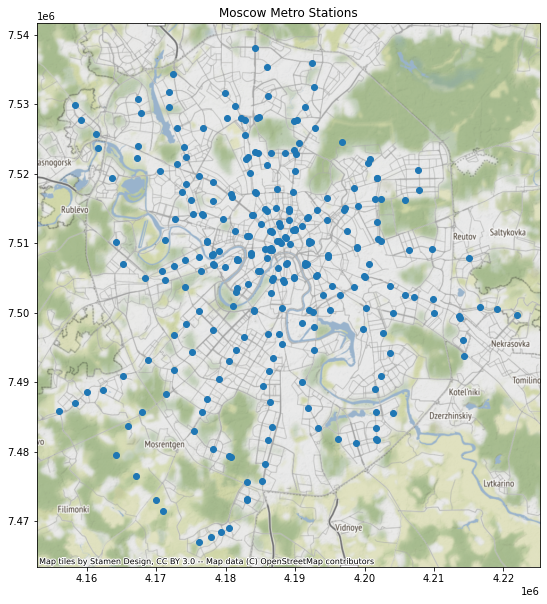

In [4]:
# Convert to the Web Mercator projection before plotting
ax = stations.to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Metro Stations")
cx.add_basemap(ax)

#### Feature

Adds the feature `metro_distance` to the `buildings` data.

In [5]:
# The Earth's radius in meters
EARTH_RADIUS = 6371000

# Create temporary columns for coordinates given in radians
stations["lon_rad"] = np.radians(stations.geometry.x)
stations["lat_rad"] = np.radians(stations.geometry.y)
buildings["lon_rad"] = np.radians(buildings.longitude)
buildings["lat_rad"] = np.radians(buildings.latitude)

# Calculate the distance to the nearest metro station for each building using
# the haversine formula with the Earth's radius as given above
buildings["metro_distance"] = buildings.apply(
    lambda row: np.min(
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((stations.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(stations.lat_rad)
                * np.sin((stations.lon_rad - row.lon_rad) / 2) ** 2
            )
        )
    ),
    axis=1,
)

# Drop the temporary radian columns
stations.drop(columns=["lon_rad", "lat_rad"], inplace=True)
buildings.drop(columns=["lon_rad", "lat_rad"], inplace=True)

#### Plot buildings colored by distance to nearest metro station

In [6]:
# Commented out because the resulting map is useless due to the buildings in the testing set located far outside of Moscow
# ax = buildings.to_crs(epsg=3857).plot(figsize=(15,15), legend=True, column="metro_distance", vmax=5000, markersize=10)
# stations.to_crs(epsg=3857).plot(ax=ax, color="r", marker="*")
# ax.set_title("Distance to Nearest Metro Stations")
# cx.add_basemap(ax)